#First, we get some important libraries and import the data.

## **First, we get some important libraries and import the data.**

In [ ]:
import numpy as np
import pandas as pd
import tqdm.notebook as tq
import random
import math
import pickle
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
from sklearn import svm, metrics
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #For ploting
import torch    #Pytorch
import os
import torchvision.transforms as tt #To apply transformations to the dataset, augmenting it and transforming it to a tensor.
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder #Load dataset
from PIL import Image
from torchvision import utils
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

# check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
##########################################
# ACTION NEEDED! Change to a relevant path
##########################################
path = '/content/gdrive/MyDrive/Deep Learning/Data/Splits Pics'

In [ ]:
# Look into the data directory
data_dir = path
print(os.listdir(data_dir))
print(len(os.listdir(data_dir)))


['Left1_splitLeft.jpg', 'Left13_splitLeft.jpg', 'Left10_splitRight.jpg', 'Left12_splitLeft.jpg', 'Left1_splitRight.jpg', 'Left10_splitLeft.jpg', 'Left11_splitLeft.jpg', 'Left12_splitRight.jpg', 'Left13_splitRight.jpg', 'Left11_splitRight.jpg', 'Left20_splitRight.jpg', 'Left2_splitRight.jpg', 'Left14_splitRight.jpg', 'Left17_splitRight.jpg', 'Left18_splitRight.jpg', 'Left15_splitRight.jpg', 'Left14_splitLeft.jpg', 'Left18_splitLeft.jpg', 'Left17_splitLeft.jpg', 'Left16_splitLeft.jpg', 'Left15_splitLeft.jpg', 'Left20_splitLeft.jpg', 'Left16_splitRight.jpg', 'Left19_splitRight.jpg', 'Left2_splitLeft.jpg', 'Left19_splitLeft.jpg', 'Left23_splitLeft.jpg', 'Left24_splitLeft.jpg', 'Left24_splitRight.jpg', 'Left21_splitLeft.jpg', 'Left22_splitLeft.jpg', 'Left23_splitRight.jpg', 'Left21_splitRight.jpg', 'Left22_splitRight.jpg', 'Left29_splitRight.jpg', 'Left30_splitRight.jpg', 'Left27_splitLeft.jpg', 'Left25_splitLeft.jpg', 'Left3_splitRight.jpg', 'Left26_splitLeft.jpg', 'Left3_splitLeft.jpg', '

In [ ]:
train_data, val_data =train_test_split(os.listdir(data_dir), test_size=0.2, random_state=42)

In [ ]:
# import shutil
# output_dir = '/content/gdrive/MyDrive/Deep Learning/Data/train_data_dir'
# os.makedirs(output_dir, exist_ok=True)
# for p in train_data:
#   shutil.copy2(os.path.join(path, p), os.path.join(output_dir,p))

In [ ]:
# output_dir = '/content/gdrive/MyDrive/Deep Learning/Data/val_data_dir'
# os.makedirs(output_dir, exist_ok=True)
# for p in val_data:
#   shutil.copy2(os.path.join(path, p), os.path.join(output_dir,p))

In [ ]:
! git clone https://github.com/erdemuysalx/bone_fracture_classification.git

Cloning into 'bone_fracture_classification'...
remote: Enumerating objects: 117, done.
remote: Total 117 (delta 0), reused 0 (delta 0), pack-reused 117
Receiving objects: 100% (117/117), 85.00 MiB | 36.50 MiB/s, done.
Resolving deltas: 100% (42/42), done.


In [ ]:
!git clone https://github.com/jacobgil/pytorch-grad-cam

Cloning into 'pytorch-grad-cam'...
remote: Enumerating objects: 878, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 878 (delta 89), reused 127 (delta 62), pack-reused 702
Receiving objects: 100% (878/878), 25.74 MiB | 30.75 MiB/s, done.
Resolving deltas: 100% (469/469), done.


## **Creating the datasets**

Now, we define the transformations to be applied to the images. This way we augment the dataset, allowing for better generalization and helping prevent overfitting.

In [ ]:
#Transformations aplied to test DS.
train_tf = tt.Compose([         
    #tt.ColorJitter(brightness=0.2),
    tt.Resize(size=(150,150)),
    #tt.RandomAffine(shear=(-5, 5)),
    tt.RandomHorizontalFlip(0.3),
    tt.RandomRotation(degrees=(-5, 5)),

    tt.ToTensor(),  
])

#Transformations aplied to test DS.
val_tf= tt.Compose([   
    tt.Resize(size=(150,150)),
    tt.ToTensor(),
])

create custom dataset class for our data

In [ ]:
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader

class HipFractureDataSet(Dataset):
    """Hip Fracture Data Set."""

    def __init__(self, root_dir, file_list, is_train=True, transform=None):

        self.root_dir = root_dir
        self.file_list = file_list
        self.is_train = is_train
        self.transform = transform
        self.classes = {0:"0", 1:"1"}

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        p = self.file_list[idx] 
        img_name = os.path.join(self.root_dir, p)
        image = Image.open(img_name)

        label = 0
        if p[:4] == "Left":
          if "splitLeft" in p:
            label = 1
        elif p[:5] == "Right":
          if "splitRight" in p:
            label = 1
        if self.transform:
            image = self.transform(image)
        image = np.array(image, dtype=np.float32)

        return image, np.array(label)

define train, validation dataloaders 

In [ ]:

train_dir = '/content/gdrive/MyDrive/Deep Learning/Data/train_data_dir'
train_data = os.listdir(train_dir)
train_ds = HipFractureDataSet(train_dir, train_data, transform=train_tf)

train_loader = torch.utils.data.DataLoader(
          train_ds, batch_size=4, shuffle=True,
          pin_memory=True)

val_dir = '/content/gdrive/MyDrive/Deep Learning/Data/val_data_dir'
val_data = os.listdir(val_dir)

val_ds = HipFractureDataSet(val_dir, val_data, transform=val_tf)

val_loader = torch.utils.data.DataLoader(
          train_ds, batch_size=1, shuffle=False,
          pin_memory=True)




Showing some information about the dataset.

In [ ]:
def ds_info(dataset):
    dataset_size=len(dataset)
    classes = dataset.classes
    num_classes = len(classes)
    
    #Initialize list
    count = []     
    for x in range(num_classes):
        count.append(0)
        
    #Count every label
    for x in range(dataset_size):
        count[dataset[x][1]]+=1
        
    print('Size of the dataset:' + str(dataset_size))
    print('Number of classes:' + str(num_classes))    
    print('Samples for every class:')
    
    #Print the count
    for x in range(num_classes):
        print(classes[x] + " : " + str(count[x]))


In [ ]:
ds_info(train_ds)
ds_info(val_ds)

Size of the dataset:155
Number of classes:2
Samples for every class:
0 : 77
1 : 78
Size of the dataset:39
Number of classes:2
Samples for every class:
0 : 20
1 : 19


Next let's separate the data in batches, so we can load them on the GPU later and pass them through the networks.

It's a good idea to visualize some of the samples to see if transformations make sense and aren’t too disruptive of the original data.



In [ ]:
from torchvision.utils import make_grid

In [ ]:
def show_batch(dl):
  fig, ax = plt.subplots(figsize=(15, 15))
  ax.set_xticks([]); ax.set_yticks([])
  images = []
  for img, labels in dl:
    images.append(img)
  torch_tensor = torch.from_numpy(np.array(images))
  x = make_grid(torch_tensor, nrow=12)
  ax.imshow(x.permute(1, 2, 0))
        

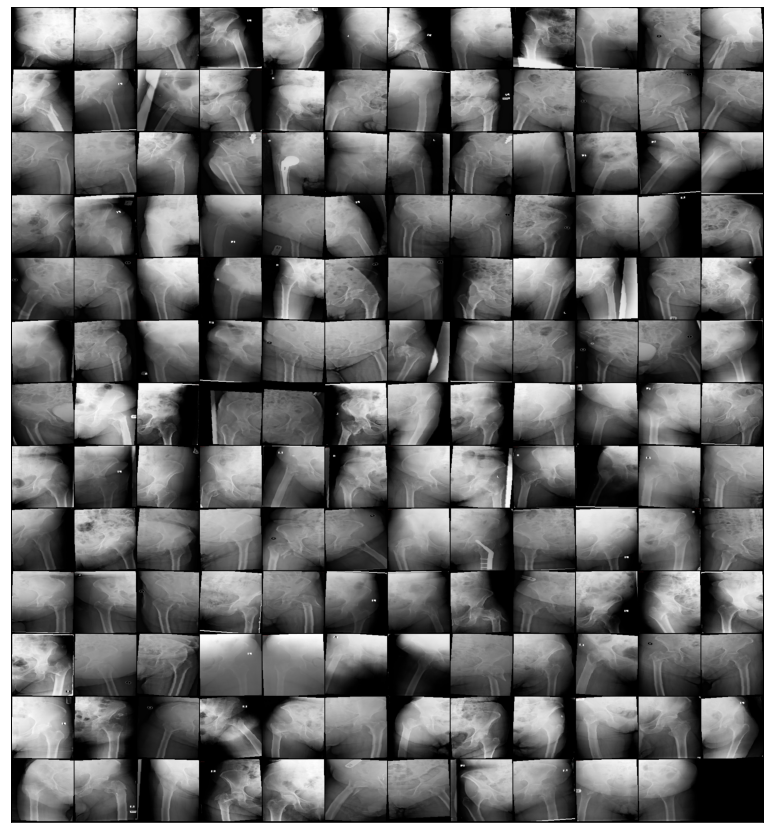

In [ ]:
show_batch(train_ds)

## **Creating the Networks**

For the first run we're going to create the base network class, this way we can define steps that are general for training and data handling that’s independent (to a certain degree) of the specific network architecture.

We create an accuracy function that counts the amount of correct predictions and divides it with the size of the batch. It gives us a metric of how good the network it's getting.

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step((img.to(device), labels.to(device))) for  img, labels in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader)) 
    for epoch in range(epochs):
      # Training Phase 
      model.train()
      train_losses = []
      lrs = []
      loop = tqdm(train_loader, leave=True)
      for img, labels in loop:
          img = img.to(device)
          labels = labels.to(device)
          loss = model.training_step((img, labels))
          train_losses.append(loss.item())
          loss.backward()
          # Gradient clipping
          if grad_clip: 
              nn.utils.clip_grad_value_(model.parameters(), grad_clip)
          optimizer.step()
          optimizer.zero_grad()
          # Record & update learning rate
          lrs.append(get_lr(optimizer))
          sched.step()
          loop.set_postfix(loss=np.mean(train_losses))

      #Validation phase
      result = evaluate(model, val_loader)
      result['train_loss'] = np.mean(train_losses)
      result['lrs'] = lrs
      model.epoch_end(epoch, result)
      history.append(result)
    return history

In [ ]:
def plot_scores(history):
    scores = [x['val_acc'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            (epoch+1), result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def show_sample(img, target):
    plt.imshow(img.permute(1, 2, 0))
    print('Labels:', target)
    
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    show_sample(img,val_ds.classes[preds[0].item()])

# constract models architectures 

**ResNet9**

Now we define the specific network architecture.
First, we build a small ResNet from each of its layers, which are a series of convolutional blocks that encapsulate a convolutional layer, normalization of the data, a nonlinear activation function (RELU) and in some steps a max pooling layer.

On this specific implementation the architecture it's as follows:

1. **Convolutional Block (CL-Norm-ReLu),          output shape: 32x150x150**
1. **Convolutional Block (CL-Norm-ReLu-MaxPool4), output shape: 64x37x37**
1. **Residual Block (ConvB-ConvB),                output shape: 64x37x37**
1. **Convolutional Block (CL-Norm-ReLu-MaxPool4), output shape: 128x9x9**
1. **Convolutional Block (CL-Norm-ReLu-MaxPool4), output shape: 256x2x2**
1. **Residual Block (ConvB-ConvB),                output shape: 256x2x2**
1. **Final block (MaxPool2-Lineal Layer),         output shape: 6**

Now, because residual block is actually a couple of convolutional blocks, this means this network has 9 "blocks", so it is called ResNet9.


In [ ]:
def conv_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1, pool=False, p_size=2):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(p_size))
    return nn.Sequential(*layers)

In [ ]:
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 32)                             #32x150x150
        self.conv2 = conv_block(32, 64, pool=True,p_size=4)                  #64x37x37
        self.res1 = nn.Sequential(conv_block(64, 64), conv_block(64, 64))
        
        self.conv3 = conv_block(64, 128, pool=True,p_size=4)                 #128x9x9
        self.conv4 = conv_block(128, 256, pool=True,p_size=4)                #256x2x2
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(2),                     #256x1x1
                                        nn.Flatten(), 
                                        nn.Linear(256, num_classes))
        
    def forward(self, xb):
        
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        
        out = self.classifier(out)
        
        return out

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out



class ResNet34(ImageClassificationBase):

    def __init__(self, in_dim, block, layers, num_classes):
        self.inplanes = 64
        super(ResNet34, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(5, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
    
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        return logits



def resnet34(in_channels, num_classes):
    """Constructs a ResNet-34 model."""
    model = ResNet34(in_channels, block=BasicBlock, 
                   layers=[3, 4, 6, 3],
                   num_classes=num_classes,
                   )
    return model

In [ ]:
class vgg16(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1_1 = conv_block(in_channels, 64)        
        self.conv1_2 = conv_block(64, 64, pool=True)                      #32x150x150

        self.conv2_1 = conv_block(64, 128)  
        self.conv2_2 = conv_block(128, 128, pool=True)  

        self.conv3_1 = conv_block(128, 256)  
        self.conv3_2 = conv_block(256, 256) 
        self.conv3_3 = conv_block(256, 256, pool=True)  

        self.conv4_1 = conv_block(256, 512)  
        self.conv4_2 = conv_block(512, 512) 
        self.conv4_3 = conv_block(512, 512, pool=True)  

        self.conv5_1 = conv_block(512, 512)  
        self.conv5_2 = conv_block(512, 512) 
        self.conv5_3 = conv_block(512, 512, pool=True)  

        self.classifier = nn.Sequential(nn.AvgPool2d((4,4)), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
    
    def forward(self, xb):
        
        out = self.conv1_1(xb)
        out = self.conv1_2(out)

        out = self.conv2_1(out)
        out = self.conv2_2(out)

        out = self.conv3_1(out)
        out = self.conv3_2(out)
        out = self.conv3_3(out)

        out = self.conv4_1(out)
        out = self.conv4_2(out)
        out = self.conv4_3(out)

        out = self.conv5_1(out)
        out = self.conv5_2(out)
        out = self.conv5_3(out)

        out = self.classifier(out)
        
        return out

In [ ]:
class vgg19(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1_1 = conv_block(in_channels, 64)        
        self.conv1_2 = conv_block(64, 64, pool=True)                      #32x150x150

        self.conv2_1 = conv_block(64, 128)  
        self.conv2_2 = conv_block(128, 128, pool=True)  

        self.conv3_1 = conv_block(128, 256)  
        self.conv3_2 = conv_block(256, 256) 
        self.conv3_3 = conv_block(256, 256) 
        self.conv3_4 = conv_block(256, 256, pool=True)  

        self.conv4_1 = conv_block(256, 512)  
        self.conv4_2 = conv_block(512, 512) 
        self.conv4_3 = conv_block(512, 512) 
        self.conv4_4 = conv_block(512, 512, pool=True)  

        self.conv5_1 = conv_block(512, 512)  
        self.conv5_2 = conv_block(512, 512)
        self.conv5_3 = conv_block(512, 512) 
        self.conv5_4 = conv_block(512, 512, pool=True)  

        self.classifier = nn.Sequential(nn.AvgPool2d((4,4)), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
    
    def forward(self, xb):
        
        out = self.conv1_1(xb)
        out = self.conv1_2(out)

        out = self.conv2_1(out)
        out = self.conv2_2(out)

        out = self.conv3_1(out)
        out = self.conv3_2(out)
        out = self.conv3_3(out)
        out = self.conv3_4(out)

        out = self.conv4_1(out)
        out = self.conv4_2(out)
        out = self.conv4_3(out)
        out = self.conv4_4(out)

        out = self.conv5_1(out)
        out = self.conv5_2(out)
        out = self.conv5_3(out)
        out = self.conv5_4(out)

        out = self.classifier(out)
        
        return out

In [ ]:
! pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=5c17bf4f773e642c9fb2c4a729f6bf5f5d7910ce3095f42378b92241fce2f2f1
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [ ]:
import torch
from efficientnet_pytorch import EfficientNet

In [ ]:
class efficient(ImageClassificationBase):
    def __init__(self,in_channels, num_classes, use_pretrain=True):
        super( ).__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels
        if use_pretrain:
          self.arch = EfficientNet.from_pretrained('efficientnet-b0', num_classes=self.num_classes)
        else:
          self.arch = EfficientNet.from_name('efficientnet-b0', in_channels=in_channels, num_classes=self.num_classes)
        
    def forward(self, inputs):

        output = self.arch(inputs)

        return output

In [ ]:
class mobilNetV2(ImageClassificationBase):
    def __init__(self,in_channels, num_classes):
        super( ).__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.arch = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False, num_classes=num_classes)
        
    def forward(self, inputs):

        output = self.arch(inputs)

        return output

Now we create some functions to automatize and simplify training independent of the network.

This part is showing the best way to get the plot we neeed

In [ ]:
def show_sample(img, target):
    plt.imshow(img.permute(1, 2, 0))
    print('Labels:', target)
    
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    show_sample(img,val_ds.classes[preds[0].item()])

https://jovian.ai/linkenny13/project/v/4?utm_source=embed

# train models 

## train resnet 9 and 34


In [ ]:
resnet9_model = ResNet9(3,2).to(device)

In [ ]:
history_resnet9 = fit_one_cycle(20, 0.001, resnet9_model, train_loader, val_loader, 0)

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.00010, train_loss: 0.8334, val_loss: 0.6924, val_acc: 0.5355


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.00028, train_loss: 0.8982, val_loss: 0.7848, val_acc: 0.6258


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.00052, train_loss: 0.8863, val_loss: 0.9204, val_acc: 0.5806


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.00076, train_loss: 0.6563, val_loss: 0.7865, val_acc: 0.6129


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.00094, train_loss: 0.9344, val_loss: 0.9296, val_acc: 0.5419


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.00100, train_loss: 0.8125, val_loss: 0.5830, val_acc: 0.6968


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.00099, train_loss: 0.8837, val_loss: 0.7272, val_acc: 0.6516


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.00095, train_loss: 0.7458, val_loss: 0.8973, val_acc: 0.5226


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.00089, train_loss: 0.6144, val_loss: 0.6396, val_acc: 0.6839


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [10], last_lr: 0.00081, train_loss: 0.6116, val_loss: 0.5031, val_acc: 0.7355


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [11], last_lr: 0.00072, train_loss: 0.5465, val_loss: 0.4323, val_acc: 0.8129


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [12], last_lr: 0.00061, train_loss: 0.4654, val_loss: 0.4037, val_acc: 0.8129


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [13], last_lr: 0.00050, train_loss: 0.5196, val_loss: 0.5220, val_acc: 0.7355


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [14], last_lr: 0.00039, train_loss: 0.4370, val_loss: 0.3341, val_acc: 0.8710


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [15], last_lr: 0.00028, train_loss: 0.3345, val_loss: 0.2959, val_acc: 0.9226


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [16], last_lr: 0.00019, train_loss: 0.3202, val_loss: 0.2598, val_acc: 0.9484


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [17], last_lr: 0.00011, train_loss: 0.3621, val_loss: 0.2950, val_acc: 0.9097


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [18], last_lr: 0.00005, train_loss: 0.2936, val_loss: 0.2704, val_acc: 0.9226


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [19], last_lr: 0.00001, train_loss: 0.3516, val_loss: 0.2639, val_acc: 0.9161


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [20], last_lr: 0.00000, train_loss: 0.2721, val_loss: 0.2785, val_acc: 0.9097


In [ ]:
resnet34_model = resnet34(3,2).to(device)

In [ ]:
history_resnet34 = fit_one_cycle(20, 0.001, resnet34_model, train_loader, val_loader, 0)

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.00010, train_loss: 0.7352, val_loss: 0.7003, val_acc: 0.5097


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.00028, train_loss: 0.7640, val_loss: 0.6760, val_acc: 0.5806


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.00052, train_loss: 0.8152, val_loss: 1.1059, val_acc: 0.4774


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.00076, train_loss: 0.7923, val_loss: 0.6826, val_acc: 0.6194


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.00094, train_loss: 0.8380, val_loss: 0.8034, val_acc: 0.6065


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.00100, train_loss: 0.6787, val_loss: 1.3725, val_acc: 0.4968


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.00099, train_loss: 0.7986, val_loss: 1.1931, val_acc: 0.5419


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.00095, train_loss: 0.7797, val_loss: 0.8179, val_acc: 0.5484


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.00089, train_loss: 0.5840, val_loss: 0.7568, val_acc: 0.6452


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [10], last_lr: 0.00081, train_loss: 0.6611, val_loss: 0.7250, val_acc: 0.5806


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [11], last_lr: 0.00072, train_loss: 0.6125, val_loss: 0.5804, val_acc: 0.7032


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [12], last_lr: 0.00061, train_loss: 0.6197, val_loss: 0.5283, val_acc: 0.7548


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [13], last_lr: 0.00050, train_loss: 0.5914, val_loss: 0.4115, val_acc: 0.8452


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [14], last_lr: 0.00039, train_loss: 0.5257, val_loss: 0.4259, val_acc: 0.7871


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [15], last_lr: 0.00028, train_loss: 0.4891, val_loss: 0.4543, val_acc: 0.7871


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [16], last_lr: 0.00019, train_loss: 0.4481, val_loss: 0.3443, val_acc: 0.8645


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [17], last_lr: 0.00011, train_loss: 0.4074, val_loss: 0.3911, val_acc: 0.7935


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [18], last_lr: 0.00005, train_loss: 0.3964, val_loss: 0.3054, val_acc: 0.8710


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [19], last_lr: 0.00001, train_loss: 0.3458, val_loss: 0.3284, val_acc: 0.8581


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [20], last_lr: 0.00000, train_loss: 0.3691, val_loss: 0.2927, val_acc: 0.8839


## train vgg19 and 19 models 

In [ ]:
vgg16_model = vgg16(3,2).to(device)

In [ ]:
history_vgg16 = fit_one_cycle(20, 0.001, vgg16_model, train_loader, val_loader, 0)

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.00010, train_loss: 0.8003, val_loss: 0.8881, val_acc: 0.5226


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.00028, train_loss: 0.7373, val_loss: 0.8172, val_acc: 0.5484


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.00052, train_loss: 0.7386, val_loss: 0.8164, val_acc: 0.5742


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.00076, train_loss: 0.7563, val_loss: 0.9926, val_acc: 0.5806


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.00094, train_loss: 0.7150, val_loss: 0.6513, val_acc: 0.6645


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.00100, train_loss: 0.7153, val_loss: 0.8983, val_acc: 0.5355


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.00099, train_loss: 0.7230, val_loss: 0.7170, val_acc: 0.5419


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.00095, train_loss: 0.6414, val_loss: 0.7678, val_acc: 0.5484


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.00089, train_loss: 0.6921, val_loss: 0.7298, val_acc: 0.6065


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [10], last_lr: 0.00081, train_loss: 0.6038, val_loss: 0.5687, val_acc: 0.6839


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [11], last_lr: 0.00072, train_loss: 0.6133, val_loss: 0.6496, val_acc: 0.6258


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [12], last_lr: 0.00061, train_loss: 0.6103, val_loss: 0.9027, val_acc: 0.5742


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [13], last_lr: 0.00050, train_loss: 0.6180, val_loss: 0.5995, val_acc: 0.6645


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [14], last_lr: 0.00039, train_loss: 0.5688, val_loss: 0.6186, val_acc: 0.6581


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [15], last_lr: 0.00028, train_loss: 0.5826, val_loss: 0.6119, val_acc: 0.6774


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [16], last_lr: 0.00019, train_loss: 0.6167, val_loss: 0.5374, val_acc: 0.7613


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [17], last_lr: 0.00011, train_loss: 0.5538, val_loss: 0.5223, val_acc: 0.7226


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [18], last_lr: 0.00005, train_loss: 0.5698, val_loss: 0.5047, val_acc: 0.7871


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [19], last_lr: 0.00001, train_loss: 0.5357, val_loss: 0.5111, val_acc: 0.7613


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [20], last_lr: 0.00000, train_loss: 0.5195, val_loss: 0.5168, val_acc: 0.7484


In [ ]:
vgg19_model =vgg19(3,2).to(device)

In [ ]:
history_vgg19 = fit_one_cycle(20, 0.001, vgg19_model, train_loader, val_loader, 0)

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.00010, train_loss: 0.7865, val_loss: 1.2082, val_acc: 0.4968


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.00028, train_loss: 0.8074, val_loss: 2.6354, val_acc: 0.4774


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.00052, train_loss: 0.7150, val_loss: 0.7542, val_acc: 0.4839


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.00076, train_loss: 0.7276, val_loss: 0.6852, val_acc: 0.5226


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.00094, train_loss: 0.7351, val_loss: 9.8132, val_acc: 0.5097


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.00100, train_loss: 0.7598, val_loss: 1.5308, val_acc: 0.5032


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.00099, train_loss: 0.7244, val_loss: 0.7979, val_acc: 0.5032


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.00095, train_loss: 0.7408, val_loss: 0.6856, val_acc: 0.5226


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.00089, train_loss: 0.6990, val_loss: 1.7737, val_acc: 0.4968


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [10], last_lr: 0.00081, train_loss: 0.7266, val_loss: 0.9990, val_acc: 0.4968


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [11], last_lr: 0.00072, train_loss: 0.7364, val_loss: 0.6979, val_acc: 0.5032


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [12], last_lr: 0.00061, train_loss: 0.6962, val_loss: 0.8267, val_acc: 0.5032


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [13], last_lr: 0.00050, train_loss: 0.7241, val_loss: 0.6921, val_acc: 0.5548


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [14], last_lr: 0.00039, train_loss: 0.7083, val_loss: 0.8884, val_acc: 0.5032


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [15], last_lr: 0.00028, train_loss: 0.7036, val_loss: 0.7024, val_acc: 0.5097


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [16], last_lr: 0.00019, train_loss: 0.6916, val_loss: 0.7100, val_acc: 0.5032


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [17], last_lr: 0.00011, train_loss: 0.7003, val_loss: 0.6855, val_acc: 0.5290


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [18], last_lr: 0.00005, train_loss: 0.6713, val_loss: 0.6933, val_acc: 0.5097


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [19], last_lr: 0.00001, train_loss: 0.6921, val_loss: 0.6959, val_acc: 0.4903


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [20], last_lr: 0.00000, train_loss: 0.6927, val_loss: 0.6927, val_acc: 0.4968


## train efficint met nd mobilenet models 

In [ ]:
effi_model=efficient(3,2).to(device) 

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


In [ ]:
history_effi_model = fit_one_cycle(20, 0.001,effi_model, train_loader, val_loader,0)

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.00010, train_loss: 0.7101, val_loss: 0.6921, val_acc: 0.5097


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.00028, train_loss: 0.6538, val_loss: 0.6933, val_acc: 0.5355


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.00052, train_loss: 0.4967, val_loss: 0.5030, val_acc: 0.7613


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.00076, train_loss: 0.4843, val_loss: 0.6281, val_acc: 0.5548


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.00094, train_loss: 0.4872, val_loss: 1.5934, val_acc: 0.5290


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.00100, train_loss: 0.4853, val_loss: 0.6490, val_acc: 0.5871


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.00099, train_loss: 0.4093, val_loss: 0.2558, val_acc: 0.8839


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.00095, train_loss: 0.4609, val_loss: 0.4854, val_acc: 0.7290


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.00089, train_loss: 0.2779, val_loss: 0.3991, val_acc: 0.8968


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [10], last_lr: 0.00081, train_loss: 0.3361, val_loss: 0.1414, val_acc: 0.9548


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [11], last_lr: 0.00072, train_loss: 0.2273, val_loss: 0.0371, val_acc: 0.9871


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [12], last_lr: 0.00061, train_loss: 0.1346, val_loss: 0.1073, val_acc: 0.9613


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [13], last_lr: 0.00050, train_loss: 0.1688, val_loss: 0.0670, val_acc: 0.9677


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [14], last_lr: 0.00039, train_loss: 0.1147, val_loss: 0.0521, val_acc: 0.9806


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [15], last_lr: 0.00028, train_loss: 0.0662, val_loss: 0.0296, val_acc: 0.9871


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [16], last_lr: 0.00019, train_loss: 0.0586, val_loss: 0.0182, val_acc: 0.9935


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [17], last_lr: 0.00011, train_loss: 0.1172, val_loss: 0.0293, val_acc: 0.9935


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [18], last_lr: 0.00005, train_loss: 0.0419, val_loss: 0.0150, val_acc: 1.0000


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [19], last_lr: 0.00001, train_loss: 0.0340, val_loss: 0.0152, val_acc: 1.0000


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [20], last_lr: 0.00000, train_loss: 0.0267, val_loss: 0.0150, val_acc: 1.0000


In [ ]:
mobile_model=mobilNetV2(3,2).to(device) 

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip


In [ ]:
mobile_effi_model = fit_one_cycle(35, 0.001,mobile_model, train_loader, val_loader,0)

  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.00006, train_loss: 0.6971, val_loss: 0.6934, val_acc: 0.5032


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.00012, train_loss: 0.7082, val_loss: 0.6941, val_acc: 0.4968


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.00022, train_loss: 0.6951, val_loss: 0.6855, val_acc: 0.5419


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.00034, train_loss: 0.6856, val_loss: 0.9962, val_acc: 0.5290


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.00048, train_loss: 0.7262, val_loss: 0.9361, val_acc: 0.5032


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.00063, train_loss: 0.7242, val_loss: 0.7895, val_acc: 0.5806


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.00076, train_loss: 0.7350, val_loss: 1.2564, val_acc: 0.5484


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.00087, train_loss: 0.7384, val_loss: 1.6185, val_acc: 0.5032


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.00095, train_loss: 0.7915, val_loss: 0.9320, val_acc: 0.4968


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [10], last_lr: 0.00099, train_loss: 0.7796, val_loss: 0.7485, val_acc: 0.5097


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [11], last_lr: 0.00100, train_loss: 0.7336, val_loss: 0.9816, val_acc: 0.5032


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [12], last_lr: 0.00099, train_loss: 0.7449, val_loss: 0.6785, val_acc: 0.5806


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [13], last_lr: 0.00097, train_loss: 0.7409, val_loss: 0.8539, val_acc: 0.5161


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [14], last_lr: 0.00095, train_loss: 0.7372, val_loss: 0.6470, val_acc: 0.6323


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [15], last_lr: 0.00092, train_loss: 0.7707, val_loss: 0.7459, val_acc: 0.4968


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [16], last_lr: 0.00088, train_loss: 0.7007, val_loss: 0.6281, val_acc: 0.6839


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [17], last_lr: 0.00084, train_loss: 0.7068, val_loss: 0.6995, val_acc: 0.5355


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [18], last_lr: 0.00079, train_loss: 0.7175, val_loss: 0.6945, val_acc: 0.5032


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [19], last_lr: 0.00073, train_loss: 0.6629, val_loss: 0.6488, val_acc: 0.6194


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [20], last_lr: 0.00067, train_loss: 0.6889, val_loss: 0.6403, val_acc: 0.5742


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [21], last_lr: 0.00061, train_loss: 0.6751, val_loss: 0.6256, val_acc: 0.6452


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [22], last_lr: 0.00055, train_loss: 0.6649, val_loss: 0.6225, val_acc: 0.6774


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [23], last_lr: 0.00048, train_loss: 0.5954, val_loss: 0.6605, val_acc: 0.6323


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [24], last_lr: 0.00042, train_loss: 0.6139, val_loss: 0.5796, val_acc: 0.6903


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [25], last_lr: 0.00036, train_loss: 0.5820, val_loss: 0.4920, val_acc: 0.7484


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [26], last_lr: 0.00030, train_loss: 0.5725, val_loss: 0.4565, val_acc: 0.7742


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [27], last_lr: 0.00024, train_loss: 0.5691, val_loss: 0.3955, val_acc: 0.8452


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [28], last_lr: 0.00019, train_loss: 0.5477, val_loss: 0.4191, val_acc: 0.7935


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [29], last_lr: 0.00014, train_loss: 0.5175, val_loss: 0.4361, val_acc: 0.7935


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [30], last_lr: 0.00010, train_loss: 0.4377, val_loss: 0.3455, val_acc: 0.8774


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [31], last_lr: 0.00006, train_loss: 0.4396, val_loss: 0.3558, val_acc: 0.8581


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [32], last_lr: 0.00004, train_loss: 0.3975, val_loss: 0.4037, val_acc: 0.8194


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [33], last_lr: 0.00002, train_loss: 0.4735, val_loss: 0.3519, val_acc: 0.8581


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [34], last_lr: 0.00000, train_loss: 0.5050, val_loss: 0.2930, val_acc: 0.8645


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch [35], last_lr: 0.00000, train_loss: 0.4389, val_loss: 0.3696, val_acc: 0.8387


saving the model after the traing

In [ ]:
PATH ='/content/gdrive/MyDrive/Deep Learning/Project_exp/Results/my_models.pt'

In [ ]:

####Saving the model###
###Action is needed ### 
######CHANGING THE PATH PF THE MODEL FOR THE SAVING AND EACH SAVE!!!######


torch.save({
            'Vgg_16_state_dict': vgg16_model.state_dict(),
            'Vgg_19_state_dict': vgg19_model.state_dict(),
            'Resnet_9_state_dict': resnet9_model.state_dict(),
            'Resnet_34_state_dict': resnet34_model.state_dict(),
            'efficient_state_dict': effi_model.state_dict(),
            "mobilenet_staet_dict": mobile_model.state_dict()}, PATH)

loading the model 

In [ ]:

####lOADING the model###
###Action is needed ### 
######CHANGING THE PATH PF THE MODEL FOR THE LOAD AND EACH SAVE!!!######

model_VGG_16 = vgg16(3,2).to(device) 
model_VGG_19 = vgg19(3,2).to(device) 
model_Resnet_34 = resnet34(3,2).to(device) 
model_Resnet_9 = ResNet9(3,2).to(device) 
effi_model=efficient(3,2).to(device) 

checkpoint = torch.load(PATH)
model_VGG_16.load_state_dict(checkpoint['Vgg_16_state_dict'])
model_VGG_19.load_state_dict(checkpoint['Vgg_19_state_dict'])
model_Resnet_34.load_state_dict(checkpoint['Resnet_34_state_dict'])
model_Resnet_9.load_state_dict(checkpoint['Resnet_9_state_dict'])
effi_model.load_state_dict(checkpoint['efficient_state_dict'])
mobile_model.load_state_dict(checkpoint['mobilenet_staet_dict'])

model_VGG_16.eval()
model_VGG_19.eval()
model_Resnet_34.eval()
model_Resnet_9.eval()
effi_model.eval();
mobile_model.eval();
# - or -
# modelA.train()
# modelB.train()

# evaluate models

## confution matrix

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(cm, title):

  ax = sns.heatmap(cm, annot=True, cmap='Blues')
  ax.set_title(title);
  ax.set_xlabel('\nPredicted Category')
  ax.set_ylabel('Actual Category ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['no_fracture','fracture'])
  ax.yaxis.set_ticklabels(['no_fracture','fracture'])

  plt.show()



def get_confusion_matrix(model, name_model, val_loader):
  scores, labels = evaluate_scores(model, val_loader)
  labels = np.array(labels).reshape(-1)
  prediction = np.argmax(np.array(scores).squeeze(), axis=-1)

  title = f"{name_model}_confusion_matrix"
  cm = confusion_matrix(labels, prediction)
  plot_cm(cm, title)

  

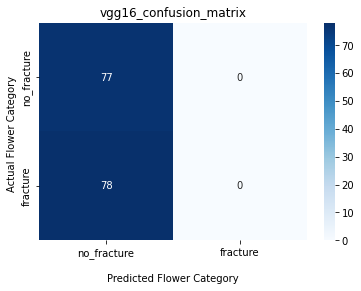

In [ ]:
get_confusion_matrix(model_VGG_16, "vgg16", val_loader)

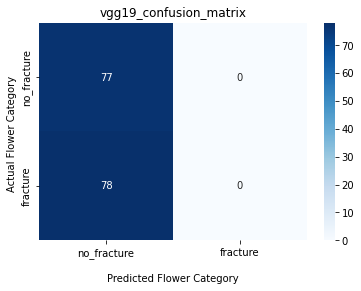

In [ ]:
get_confusion_matrix(model_VGG_19, "vgg19", val_loader)

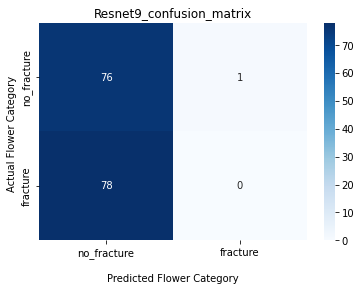

In [ ]:
get_confusion_matrix(model_Resnet_9, "Resnet9", val_loader)

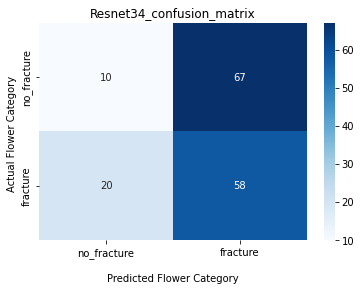

In [ ]:
get_confusion_matrix(model_Resnet_34, "Resnet34", val_loader)

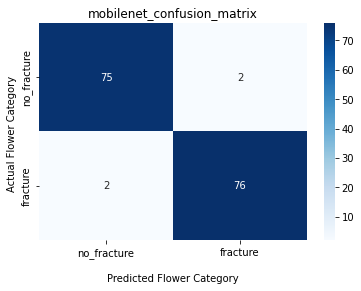

In [ ]:
get_confusion_matrix(mobile_model, "mobilenet", val_loader)

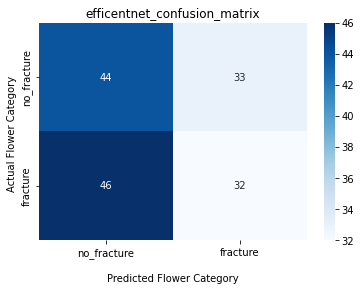

In [ ]:
get_confusion_matrix(effi_model, "efficentnet", val_loader)

## calculating THE ROC curve 

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score


@torch.no_grad()
def evaluate_scores(model, val_loader):
    model.eval()
    softmax = nn.Softmax(dim=1)

    predictions, labels = [],[]
    for  img, label in val_loader:
      pred = softmax(model(img.to(device))).cpu().numpy()
      l = label.numpy()  
      predictions.append(pred)
      labels.append(l)

    return predictions, labels


In [ ]:

def sensitivity_specificity_auc(labels, scores):

  thresholds = np.arange(start=0.1, stop=1., step=0.05)
  sensitivity_list = [] 
  specificity_list = []

  for i, threshold in enumerate(thresholds):

      y_pred = scores[:, 1] > threshold

      cm = confusion_matrix(labels, y_pred)

      sensitivity = cm[1][1] / (cm[1][0]+cm[1][1])
      specificity = 1-(cm[0][0] / (cm[0][0]+cm[0][1]))

      sensitivity_list.append(sensitivity)
      specificity_list.append(specificity)
    
  auc = roc_auc_score(labels, scores[:, 1])

  return sensitivity_list, specificity_list, auc

In [ ]:
def get_roc_valus(model, name_model, val_loader):
  scores, labels = evaluate_scores(model, val_loader)
  labels = np.array(labels).reshape(-1)
  scores = np.array(scores).squeeze()

  sensitivity_list, specificity_list, auc = sensitivity_specificity_auc(labels, scores)

  # plt.plot(specificity_list, sensitivity_list,cloer)
  # plt.title(f"model roc, auc={round(auc,3)}")
  # plt.ylabel('sensitivity')
  # plt.xlabel('1-specificity')

  # ################################ Todo:need to fix the leagend
  # plt.legend([name_model], loc='lower right')
  # plt.show()

  return sensitivity_list, specificity_list, auc


Ploting the roc curve 

In [ ]:
sensitivity_list_vgg16, specificity_list_vgg16, auc_vgg16 = get_roc_valus(model_VGG_16, "vgg16", val_loader)
sensitivity_list_vgg19, specificity_list_vgg19, auc_vgg19 = get_roc_valus(model_VGG_19, "vgg19", val_loader)
sensitivity_list_resnet_9, specificity_list_resnet_9,auc_resnet_9, = get_roc_valus(model_Resnet_9, "resnet_9",  val_loader)
sensitivity_list_resnet_34, specificity_list_resnet34, auc_resnet34 = get_roc_valus(model_Resnet_34, "resnet_34",  val_loader)
sensitivity_list_effi, specificity_list_effi, auc_effi = get_roc_valus(effi_model, "efficent",  val_loader)
sensitivity_list_mobile, specificity_list_mobil, auc_mobile = get_roc_valus(mobile_model, "efficent",  val_loader)

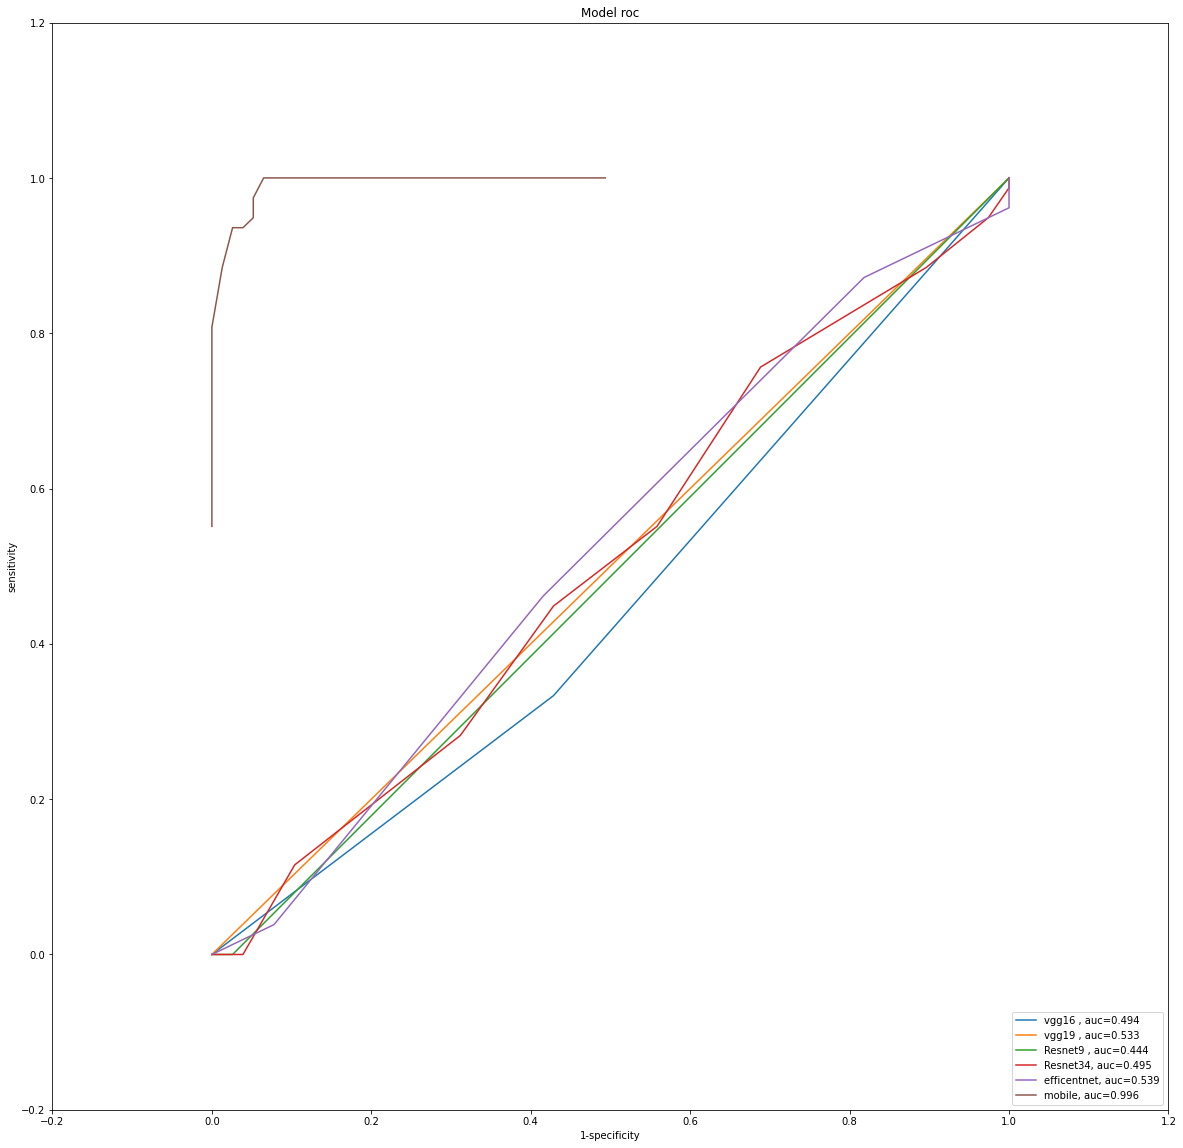

In [ ]:
plt.figure(figsize=(20,20))
plt.plot(specificity_list_vgg16, sensitivity_list_vgg16, label= f"vgg16 , auc={round(auc_vgg16,3)}")
plt.plot(specificity_list_vgg19, sensitivity_list_vgg19, label=f"vgg19 , auc={round(auc_vgg19,3)}")
plt.plot(specificity_list_resnet_9, sensitivity_list_resnet_9, label=f"Resnet9 , auc={round(auc_resnet_9,3)}")
plt.plot(specificity_list_resnet34, sensitivity_list_resnet_34, label=f"Resnet34, auc={round(auc_resnet34,3)}")
plt.plot(specificity_list_effi, sensitivity_list_effi, label=f"efficentnet, auc={round(auc_effi,3)}")
plt.plot(specificity_list_mobil, sensitivity_list_mobile, label=f"mobile, auc={round(auc_mobile,3)}")
plt.title(f"Model roc")
plt.ylabel('sensitivity')
plt.xlabel('1-specificity')

plt.xlim([-0.2, 1.2])
plt.ylim([-0.2, 1.2])

#plt.legend([name_model], loc='lower right')

plt.legend(loc='lower right')
plt.savefig('/content/gdrive/MyDrive/Deep Learning/Project_exp/Results/plt.jpg')
plt.show()




In [ ]:
train_losses = []
val_losses = []
val_accs = []
for item in history_resnet9:
  train_losses.append(item["train_loss"])
  val_losses.append(item["val_loss"])
  val_accs.append(item["val_acc"])


train_losses_34 = []
val_losses_34= []
val_accs_34 = []
for item in history_resnet34:
  train_losses_34.append(item["train_loss"])
  val_losses_34.append(item["val_loss"])
  val_accs_34.append(item["val_acc"])


train_losses_vgg16 = []
val_losses_vgg16 = []
val_accs_vgg16 = []
for item in history_vgg16:
  train_losses_vgg16.append(item["train_loss"])
  val_losses_vgg16.append(item["val_loss"])
  val_accs_vgg16.append(item["val_acc"])


train_losses_vgg19 = []
val_losses_vgg19 = []
val_accs_vgg19= []
for item in history_vgg19:
  train_losses_vgg19.append(item["train_loss"])
  val_losses_vgg19.append(item["val_loss"])
  val_accs_vgg19.append(item["val_acc"])

train_losses_efi = []
val_losses_efi = []
val_accs_efi= []
for item in history_effi_model:
  train_losses_efi.append(item["train_loss"])
  val_losses_efi.append(item["val_loss"])
  val_accs_efi.append(item["val_acc"])

train_losses_mobile = []
val_losses_mobile = []
val_accs_mobile= []
for item in mobile_effi_model:
  train_losses_mobile.append(item["train_loss"])
  val_losses_mobile.append(item["val_loss"])
  val_accs_mobile.append(item["val_acc"])



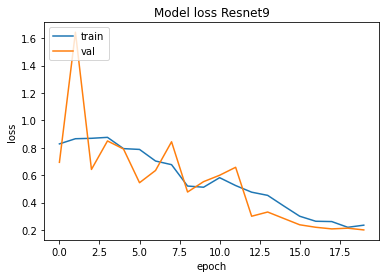

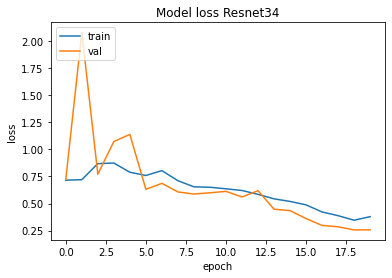

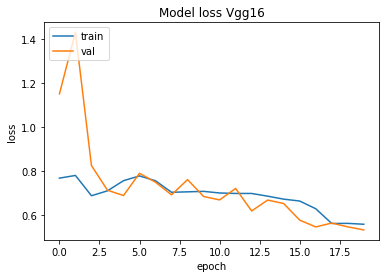

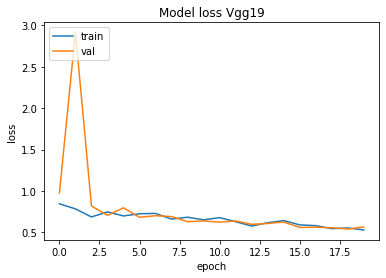

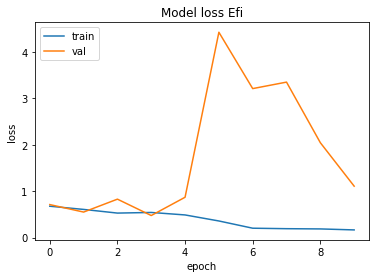

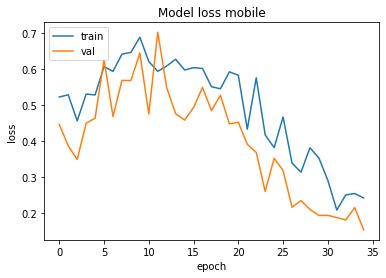

In [ ]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.title(f"Model loss Resnet9")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


plt.plot(train_losses_34)
plt.plot(val_losses_34)
plt.title(f"Model loss Resnet34")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(train_losses_vgg16)
plt.plot(val_losses_vgg16)
plt.title(f"Model loss Vgg16")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(train_losses_vgg19)
plt.plot(val_losses_vgg19)
plt.title(f"Model loss Vgg19")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(train_losses_efi)
plt.plot(val_losses_efi)
plt.title(f"Model loss Efi")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(train_losses_mobile)
plt.plot(val_losses_mobile)
plt.title(f"Model loss mobile")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()




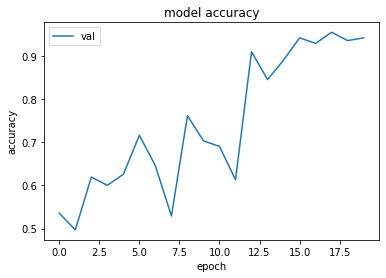

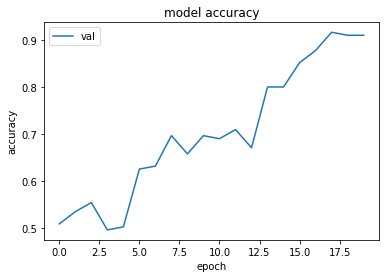

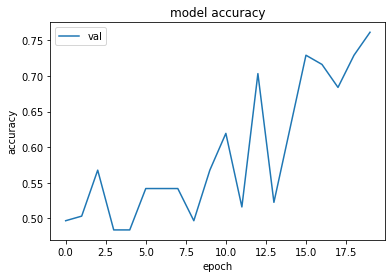

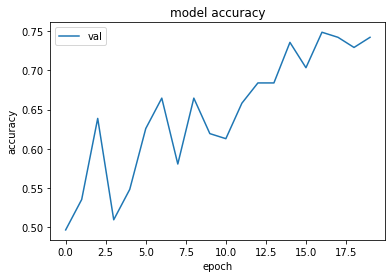

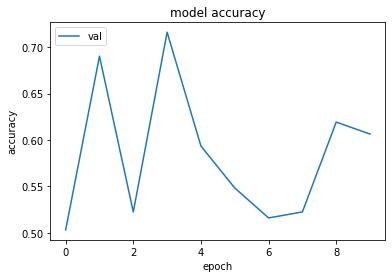

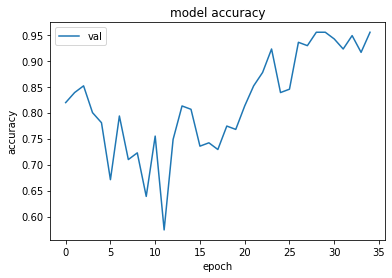

In [ ]:
plt.plot(val_accs)
plt.title(f"model accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([ 'val'], loc='upper left')
plt.show()

plt.plot(val_accs_34)
plt.title(f"model accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([ 'val'], loc='upper left')
plt.show()

plt.plot(val_accs_vgg16)
plt.title(f"model accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([ 'val'], loc='upper left')
plt.show()

plt.plot(val_accs_vgg19)
plt.title(f"model accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([ 'val'], loc='upper left')
plt.show()

plt.plot(val_accs_efi)
plt.title(f"model accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([ 'val'], loc='upper left')
plt.show()

plt.plot(val_accs_mobile)
plt.title(f"model accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([ 'val'], loc='upper left')
plt.show()

## grad cam 

In [ ]:
! pip install git+https://github.com/jacobgil/pytorch-grad-cam

In [ ]:
"""Show network train graphs and analyze training results."""
import pytorch_grad_cam
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

def get_grad_cam_visualization(test_dataset, model, target_layers):

    samples = DataLoader(dataset=test_dataset, shuffle=False, batch_size=1)

    cam = pytorch_grad_cam.GradCAM(model=model, target_layers=target_layers, use_cuda=(device!="cpu"))
    cam.batch_size = 1


    cam_imgs = []
    targets = []
    for input, target in samples:

      t = [ClassifierOutputTarget(target.cpu().numpy()[0])]
      gray_cam = cam(input_tensor=input, targets=t)
      img = input.squeeze().permute(1, 2, 0)
      img = img.numpy().clip(min=0, max=1)
      gray_cam = gray_cam[0, :]
      cam_img = pytorch_grad_cam.utils.image.show_cam_on_image(img, gray_cam, use_rgb=True)
      cam_imgs.append(np.moveaxis(cam_img, -1, 0))
      targets.append(target)

    return np.array(cam_imgs), targets

def grad_cam(model, target_layers, path):

    model.eval()
    seen_labels = []
    images = []
    
    visualization, true_label = get_grad_cam_visualization(val_ds, model, target_layers)
    grad_cam_figure = plt.figure()
    torch_tensor = torch.from_numpy(visualization)
    x = make_grid(torch_tensor, nrow=8)
    plt.figure(figsize=(20,20))
    plt.imshow(x.permute(1, 2, 0))
    plt.savefig(path)


### gradcam resnet 9

<Figure size 432x288 with 0 Axes>

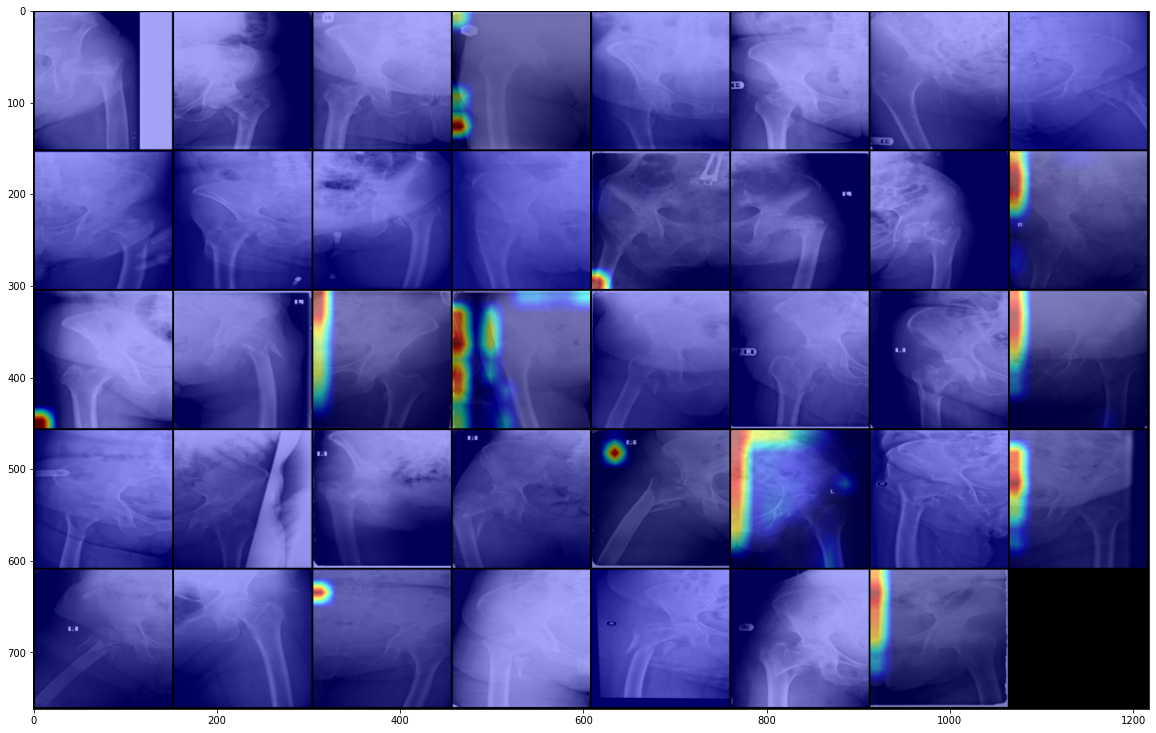

In [ ]:
path = '/content/gdrive/MyDrive/Deep Learning/Project_exp/Results/Resnet_9_gradcam.jpg'
grad_cam(model_Resnet_9, [model_Resnet_9.conv3], path )

### gradcam resnet 34

<Figure size 432x288 with 0 Axes>

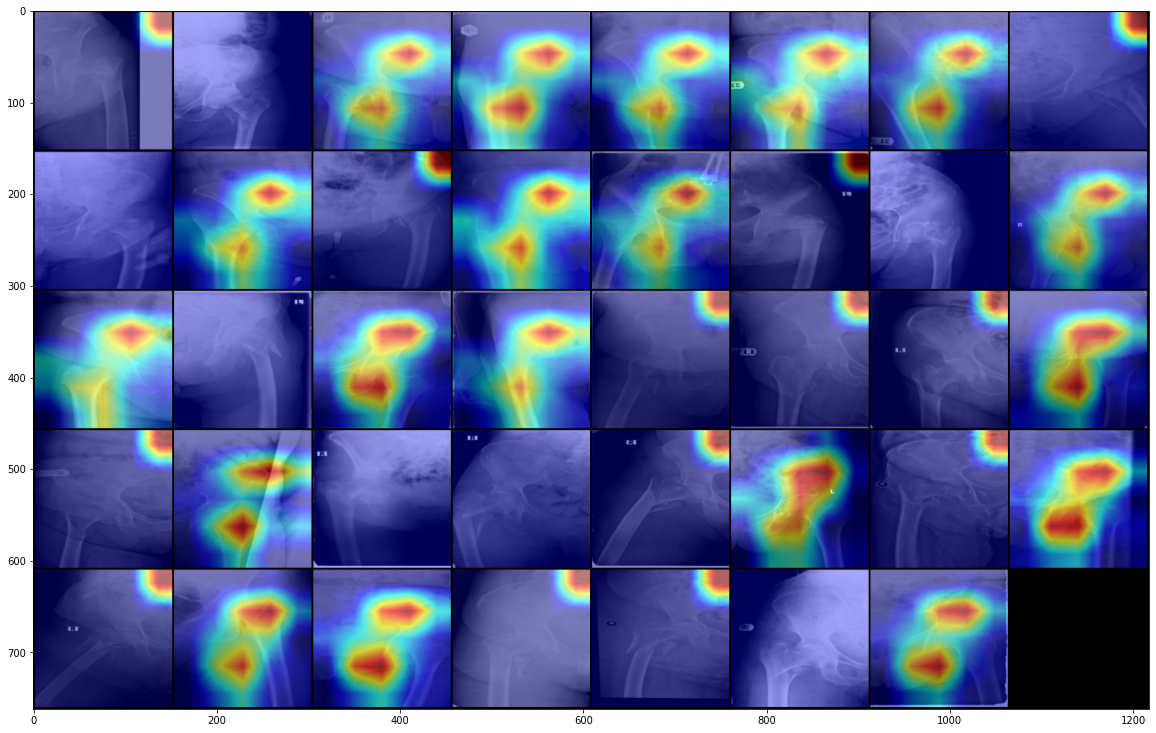

In [ ]:
path = '/content/gdrive/MyDrive/Deep Learning/Project_exp/Results/Resnet_34_gradcam.jpg'
grad_cam(model_Resnet_34, [model_Resnet_34.layer4], path)

### gradcam VGG 16

<Figure size 432x288 with 0 Axes>

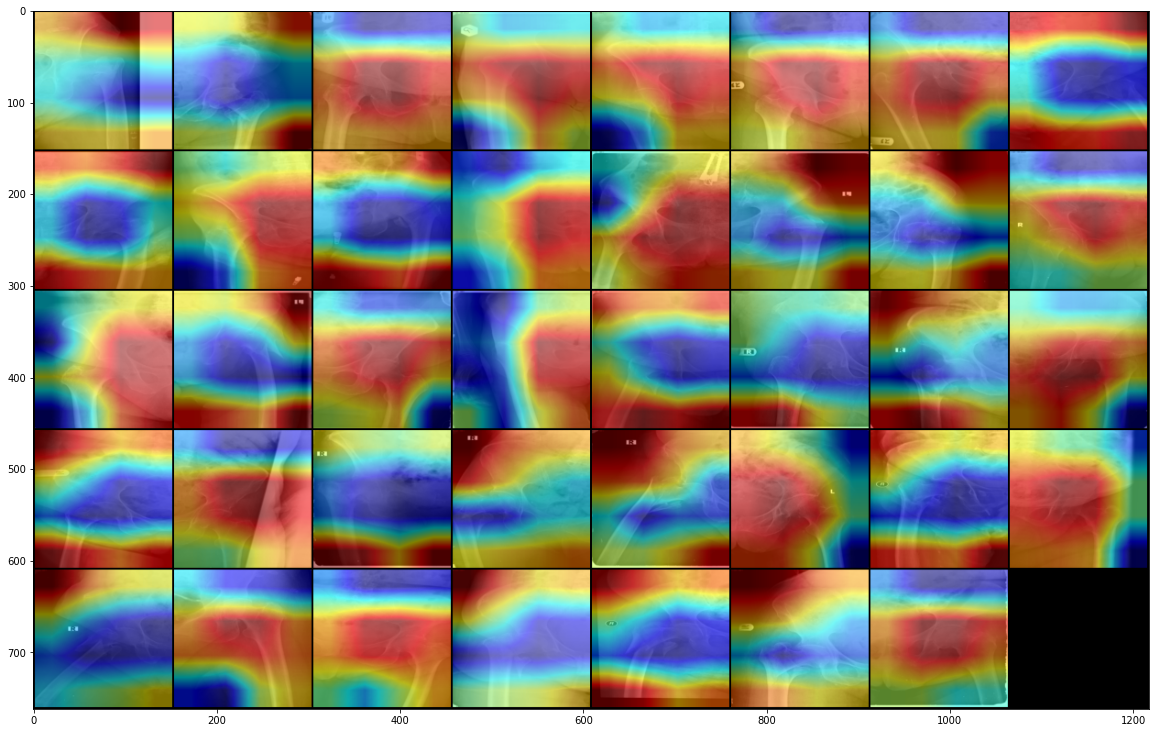

In [ ]:
path = '/content/gdrive/MyDrive/Deep Learning/Project_exp/Results/VGG_16_gradcam.jpg'
grad_cam(model_VGG_16, [model_VGG_16.conv5_3], path)

### gradcam vgg19

<Figure size 432x288 with 0 Axes>

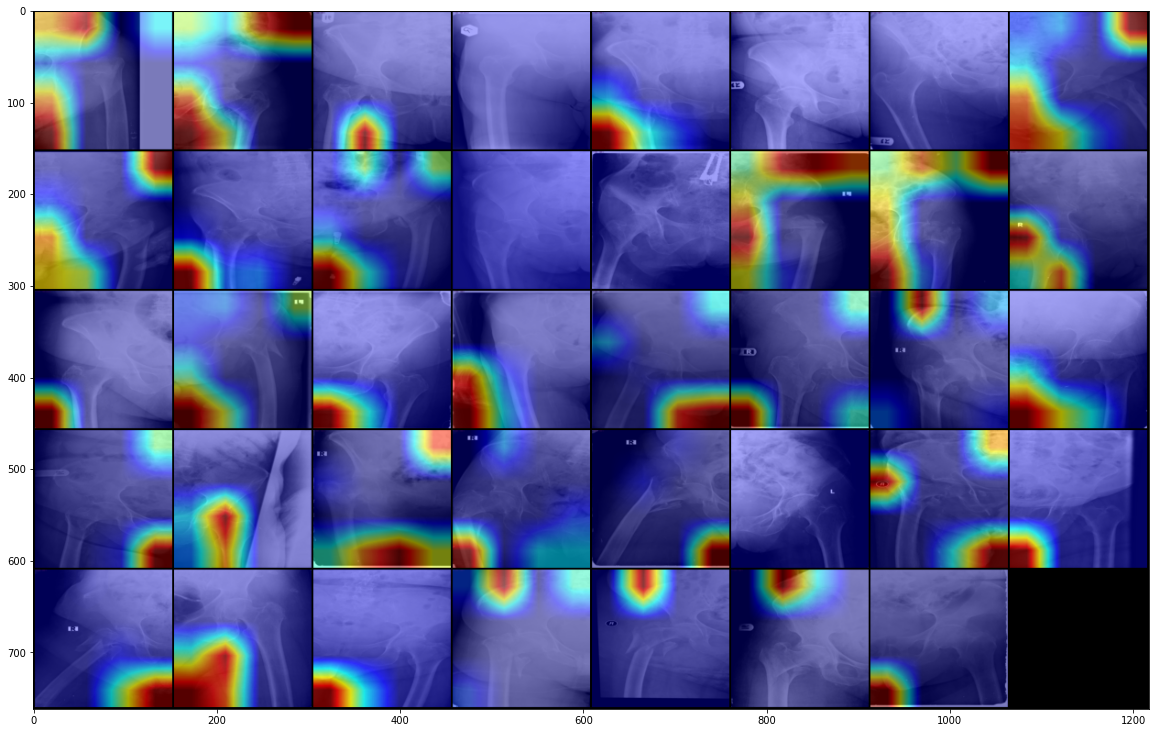

In [ ]:
path = '/content/gdrive/MyDrive/Deep Learning/Project_exp/Results/VGG_19_gradcam.jpg'
grad_cam(model_VGG_19, [model_VGG_19.conv5_4], path)

### gradcam efficient net

<Figure size 432x288 with 0 Axes>

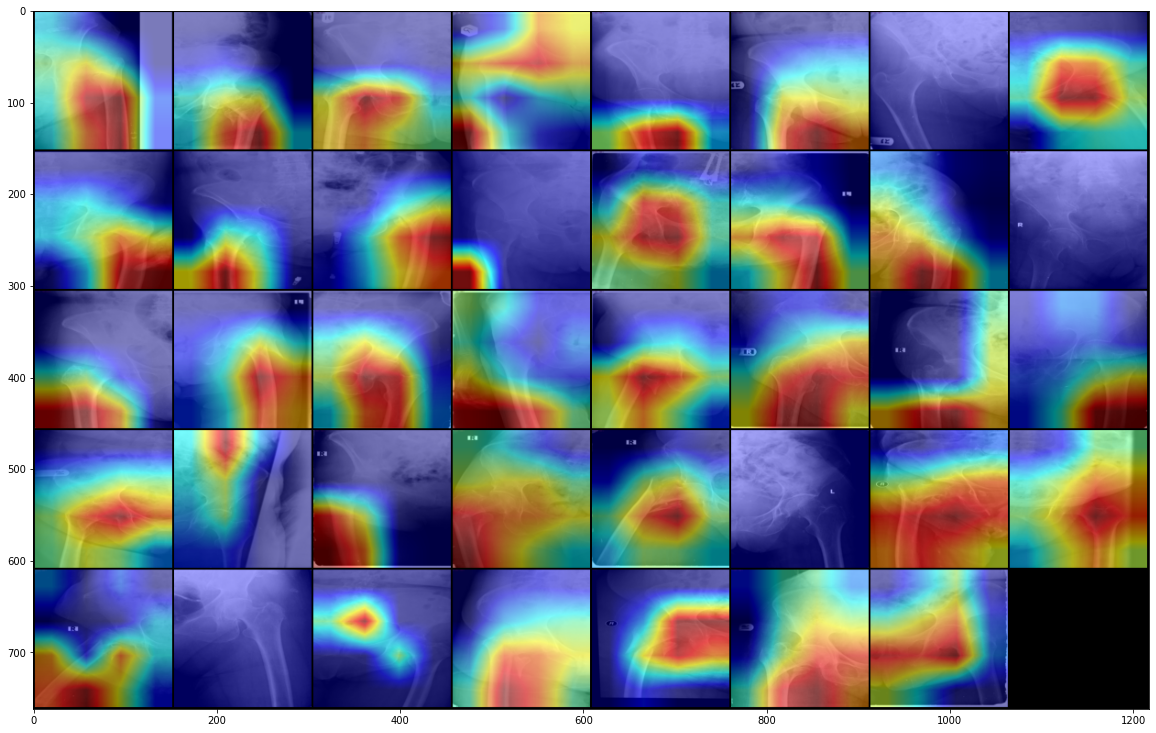

In [ ]:
path = '/content/gdrive/MyDrive/Deep Learning/Project_exp/Results/efficentnet_gradcam.jpg'
grad_cam(effi_model, [effi_model.arch._conv_head], path)

### gradcam mobile net

<Figure size 432x288 with 0 Axes>

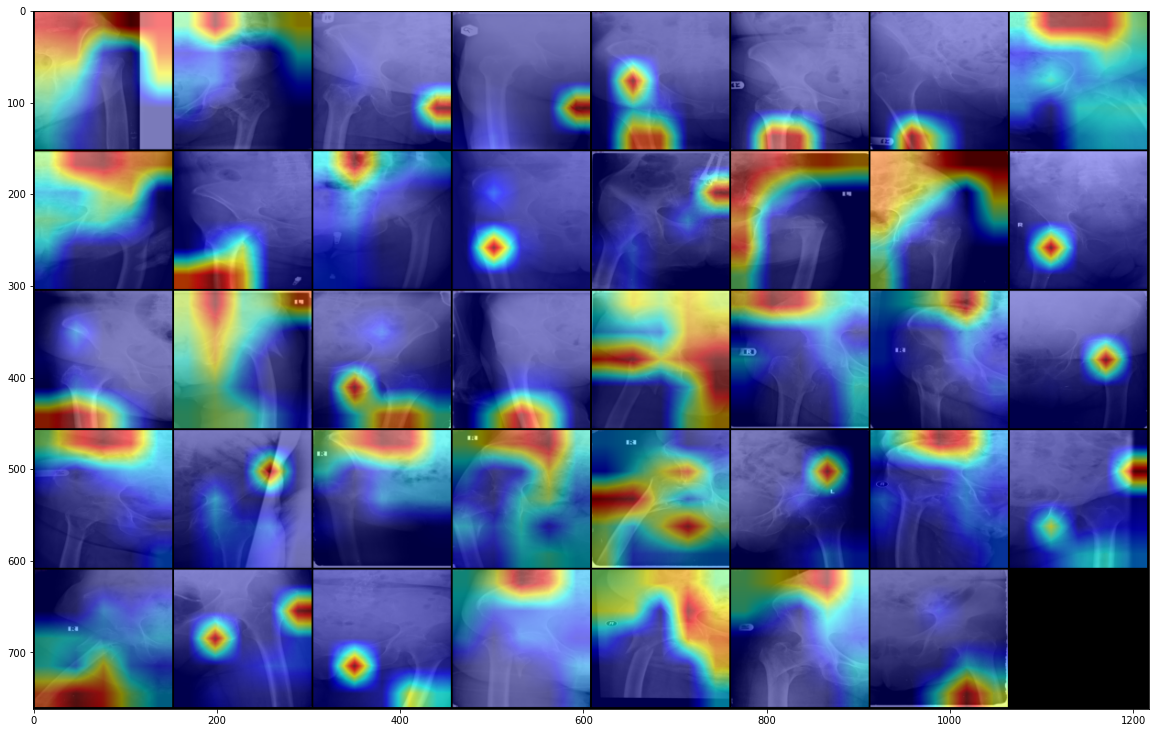

In [ ]:
path = '/content/gdrive/MyDrive/Deep Learning/Project_exp/Results/mobilenet_gradcam.jpg'
grad_cam(mobile_model, [mobile_model.arch.features[18][0]], path)